In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
import matplotlib.pyplot as plt
import diffrax
from tqdm.notebook import tqdm
import random
import numpy as np

['xy_train', 'alpha_train', 'xy_test']
(10000, 100, 2) (10000, 1)
(10000, 100, 2)


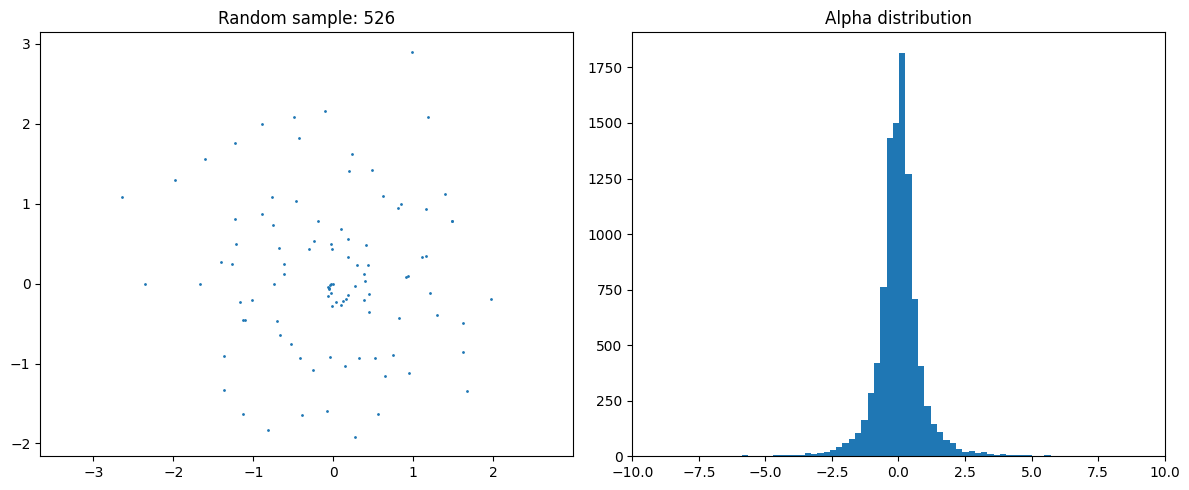

In [2]:
covid_data = jnp.load("spirals.npz")

print(covid_data.files)

xy_train = covid_data["xy_train"] # (10000, 100, 2)
xy_test = covid_data["xy_test"] # (10000, 100, 2)
alpha_train = covid_data["alpha_train"] # (10000, 1)

alpha_mean = jnp.mean(alpha_train)
alpha_std = jnp.std(alpha_train)
alpha_normalized = (alpha_train - alpha_mean) / alpha_std

xy_mean = jnp.mean(xy_train, axis=(0, 1), keepdims=True)
xy_std = jnp.std(xy_train, axis=(0, 1), keepdims=True)
xy_normalized = (xy_train - xy_mean) / xy_std

print(xy_train.shape, alpha_train.shape)
print(xy_test.shape)

rand_idx = random.randint(0, xy_train.shape[0] - 1)
x_train = xy_normalized[rand_idx, :, 0]
y_train = xy_normalized[rand_idx, :, 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# scatter of a random training sample
axes[0].scatter(x_train.flatten(), y_train.flatten(), s=1)
axes[0].set_title(f"Random sample: {rand_idx}")
axes[0].axis("equal")

# alpha distribution
axes[1].hist(alpha_normalized.flatten(), bins=100)
axes[1].set_xlim(-10, 10)
axes[1].set_title("Alpha distribution")

plt.tight_layout()
plt.show()


In [3]:
class ODEFunc(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, hidden_size: int, *, key):
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size,
            width_size=hidden_size,
            depth=1,
            key=key,
        )

    def __call__(self, t, h, args):
        # h: (hidden_size,)
        return jnp.tanh(self.mlp(h))


In [4]:
class SimpleRNNCell(eqx.Module):
    linear: eqx.nn.Linear
    hidden_size: int

    def __init__(self, input_size: int, hidden_size: int, *, key):
        self.hidden_size = hidden_size
        # Takes concatenated [h, x] -> new h
        self.linear = eqx.nn.Linear(input_size + hidden_size, hidden_size, key=key)

    def __call__(self, x, h):
        # force 1D vectors
        x = jnp.reshape(x, (-1,))   # (input_size,)
        h = jnp.reshape(h, (-1,))   # (hidden_size,)
        hx = jnp.concatenate([h, x], axis=0)      # (hidden_size + input_size,)
        return jnp.tanh(self.linear(hx))          # (hidden_size,)


In [5]:
class ODERNN(eqx.Module):
    hidden_size: int
    ode_func: ODEFunc
    rnn_cell: SimpleRNNCell
    readout: eqx.nn.Linear

    def __init__(self, input_size: int, hidden_size: int, *, key):
        k1, k2, k3 = jrandom.split(key, 3)
        self.hidden_size = hidden_size
        self.ode_func = ODEFunc(hidden_size, key=k1)
        self.rnn_cell = SimpleRNNCell(input_size, hidden_size, key=k2)
        self.readout = eqx.nn.Linear(hidden_size, 1, key=k3)

    def __call__(self, ts, xs):
        term = diffrax.ODETerm(self.ode_func)
        solver = diffrax.Dopri5()
        saveat = diffrax.SaveAt(t1=True)

        def evolve(h, t0, t1):
            sol = diffrax.diffeqsolve(
                term,
                solver,
                t0=t0,
                t1=t1,
                dt0=(t1 - t0) / 4.0,
                y0=h,
                saveat=saveat,
            )
            return jnp.reshape(sol.ys, (-1,))   # <- ensure (hidden_size,)

        h = jnp.zeros((self.hidden_size,), dtype=jnp.float32)

        T = xs.shape[0]
        for i in range(T):
            h = evolve(h, ts[i], ts[i+1])      # (hidden_size,)
            h = self.rnn_cell(xs[i], h)        # (hidden_size,)

        alpha_hat = self.readout(h)            # (1,)
        return alpha_hat, h


In [6]:
T = xy_train.shape[1]               # 100
ts = jnp.linspace(0.0, 1.0, T + 1)  # (101,)

model_key = jrandom.PRNGKey(0)
hidden_size = 64
model = ODERNN(input_size=2, hidden_size=hidden_size, key=model_key)

learning_rate = 1e-2
optim = optax.adam(learning_rate)
params = eqx.filter(model, eqx.is_array)
opt_state = optim.init(params)



In [7]:
@eqx.filter_value_and_grad()
def loss_fn(model, batch_xy, batch_alpha):
    """
    batch_xy: (B, T, 2)
    batch_alpha: (B, 1)
    """
    def forward_one(x_seq):
        pred_alpha, _ = model(ts, x_seq)   # pred_alpha: (1,)
        return pred_alpha[0]               # scalar

    preds = jax.vmap(forward_one)(batch_xy)   # (B,)
    targets = batch_alpha[:, 0]               # (B,)
    return jnp.mean((preds - targets) ** 2)

In [8]:
def get_params(model):
    return eqx.filter(model, eqx.is_inexact_array)

@eqx.filter_jit
def make_step(model, opt_state, batch_xy, batch_alpha):
    loss, grads = loss_fn(model, batch_xy, batch_alpha)

    # filter the model in the same way as for opt_state / grads
    params = eqx.filter(model, eqx.is_array)

    updates, opt_state = optim.update(grads, opt_state, params)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss



In [9]:
def dataloader(arrays, batch_size):
    """Simple NumPy dataloader, like the Equinox examples."""
    dataset_size = arrays[0].shape[0]
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        while start + batch_size <= dataset_size:
            batch_idx = perm[start:start + batch_size]
            yield tuple(arr[batch_idx] for arr in arrays)
            start += batch_size


In [10]:
x_seq = xy_normalized[0]                  # (T, 2)
alpha_hat, h = model(ts, x_seq)
print("alpha_hat shape:", alpha_hat.shape)
print("h shape:", h.shape)


alpha_hat shape: (1,)
h shape: (64,)


In [11]:
# Move training data to NumPy for the dataloader
xy_train_np = np.array(xy_normalized)
alpha_train_np = np.array(alpha_normalized)

batch_size = 64
epochs = 3

loader = dataloader((xy_train_np, alpha_train_np), batch_size)

num_steps_per_epoch = xy_train_np.shape[0] // batch_size

loss_history = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for _ in tqdm(range(num_steps_per_epoch), desc=f"Epoch {epoch+1}/{epochs}"):
        batch_xy_np, batch_alpha_np = next(loader)
        batch_xy = jnp.array(batch_xy_np)         # (B, T, 2)
        batch_alpha = jnp.array(batch_alpha_np)   # (B, 1)

        model, opt_state, loss = make_step(model, opt_state, batch_xy, batch_alpha)
        epoch_loss += float(loss)

    epoch_loss /= num_steps_per_epoch
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}: MSE = {epoch_loss:.4f}")


Epoch 1/3:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1: MSE = 1.0409


Epoch 2/3:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2: MSE = 1.0271


Epoch 3/3:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3: MSE = 1.0307


  0%|          | 0/100 [00:00<?, ?it/s]

Final training MSE: 5.2044
[0.17087299 0.16064128 0.17836732 0.11181187 0.17894939 0.16729374
 0.1535538  0.17242134 0.17343405 0.16140534]


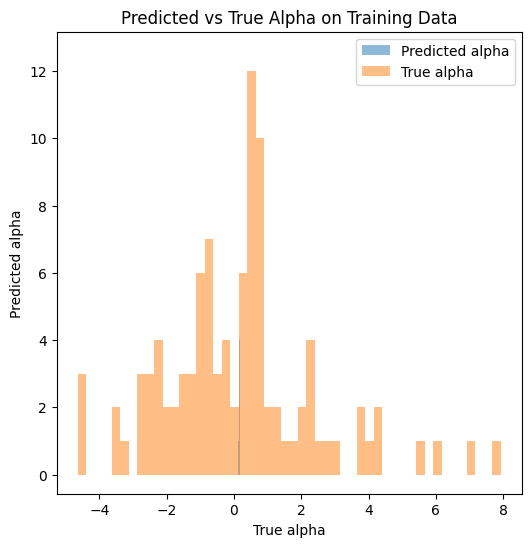

In [12]:
#predictalpha_train
n = 100
alpha_preds = []
for i in tqdm(range(n)):
    x_seq = xy_normalized[i]  # (T, 2)
    pred_alpha, _ = model(ts, x_seq)  # (1,)
    pred_alpha = pred_alpha * alpha_std + alpha_mean
    alpha_preds.append(float(pred_alpha[0]))
    
alpha_preds = jnp.array(alpha_preds)  # (N,)
mse_train = jnp.mean((alpha_preds - alpha_train[:n, 0]) ** 2)
print(f"Final training MSE: {mse_train:.4f}")

print(alpha_preds[:10])

# plot predicted vs true alpha
plt.figure(figsize=(6, 6))
plt.hist(alpha_preds, bins=50, alpha=0.5, label="Predicted alpha")
plt.hist(alpha_train[:n, 0], bins=50, alpha=0.5, label="True alpha")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel("True alpha")
plt.ylabel("Predicted alpha")
plt.title("Predicted vs True Alpha on Training Data")
plt.axis("equal")
plt.legend()
plt.show()